In [1]:
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pprint
import os
from shutil import copyfile
from tqdm.notebook import tqdm
import pandas as pd
import h5py
from numba import jit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask

import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# test model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Vnet model

In [2]:
from tensorflow.keras import optimizers, initializers, regularizers

def prepare_vnet_encoder(config, inputs, trainable=True):
    prev_output = inputs
    regularizer = regularizers.l2(0.001)
    save_layers = []
    
    
    for i in range(len(config)):
        layer_prev_output = prev_output
        for j in range(config[i][1]):
            c = layers.Conv2D(config[i][0], (5, 5), kernel_initializer='he_normal',
                              trainable=trainable, kernel_regularizer=regularizer,
                              padding='same', name='dw_c{}_{}'.format(i, j))(prev_output)
            
            # skip connection
            if j == config[i][1] - 1 and i != 0:
                c = layers.Add()([c, layer_prev_output])
              
            c = layers.Activation('elu')(c)
            c = tf.keras.layers.BatchNormalization()(c)
                
            prev_output = c
        
        # down convolution
        if i != len(config) -1:
            save_layers.append(c)
            c = layers.Conv2D(config[i][0] * 2, (2, 2), strides=2, kernel_initializer='he_normal',
                              trainable=trainable, kernel_regularizer=regularizer, activation='elu',
                              padding='same', name='p_cd{}_{}'.format(i, j))(c)
            c = tf.keras.layers.BatchNormalization()(c)
            prev_output = c
    
    return prev_output, save_layers
        
def prepare_vnet_decoder(config, inputs, skip_layers, trainable=True):
    prev_output = inputs
    regularizer = regularizers.l2(0.001)
    
    for i in range(len(config)):
        # up deconvolution
        u = layers.Conv2DTranspose(config[i][0], (2, 2), strides=(2, 2), activation='elu',
                                   kernel_initializer='he_normal', trainable=trainable,
                                   padding='same', name='up_u{}_1'.format(i))(prev_output)
        u = tf.keras.layers.BatchNormalization()(u)
        layer_prev_output = u
        prev_output = u        
        for j in range(config[i][1]):
            # long skip connection
            if j == 0:
                c = layers.concatenate([prev_output, skip_layers[-(i+1)]])
            else:
                c = prev_output

            c = layers.Conv2D(config[i][0], (5, 5), kernel_initializer='he_normal', trainable=trainable,
                            kernel_regularizer=regularizer, padding='same', name='up_cd{}_{}'.format(i, j))(c)
            
            # short skip connection
            if j == config[i][1] -1:
                c = layers.Add()([c, layer_prev_output])
            
            c = layers.Activation('elu')(c)
            c = tf.keras.layers.BatchNormalization()(c)
                
        prev_output = c
        
    return prev_output
        
def prepare_vnet(config, weight_path=None):
    input_shape = config['input_size']
    output_size = config['output_size']
    loss_function = config['loss_function']
    

    #Build the model
    inputs = tf.keras.layers.Input(input_shape)
    
    encoder_config = [[16, 1], [32, 2], [64, 3], [128, 3], [256, 3]]
    encoder, skip_layers = prepare_vnet_encoder(encoder_config, inputs)
    
    decoder_config = [[128, 3], [64, 3], [32, 2], [16, 1]]
    decoder = prepare_vnet_decoder(decoder_config, encoder, skip_layers)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder)
    full_model = keras.Model(inputs=inputs,
                             outputs=outputs)

    if weight_path is not None:
        full_model.load_weights(weight_path)

    full_model.compile(optimizer='adam',
                       loss=loss_function,
                       metrics=['mae'])
    return full_model

size = 256
test_config={
    "input_size": (size, size, 1),
    "output_size": (size, size, 1),
    "loss_function": 'mse'
}


model = None
model = prepare_vnet(test_config)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
dw_c0_0 (Conv2D)                (None, 256, 256, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           dw_c0_0[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          activation[0][0]                 
______________________________________________________________________________________________

# Pre-train with Micai dataset

## Preprocessing data

In [3]:
def random_crop(x, y, size, number, dims=1):
    x_result = None
    y_result = None
    max_index = len(x)
    
    for i in tqdm(range(max_index)):
        x_crop = extract_patches_2d(x[i], (size,size), number, i*100)
        y_crop = extract_patches_2d(y[i], (size,size), number, i*100)
        
        if x_result is None:
            x_result = x_crop
            y_result = y_crop
        else:
            x_result = np.concatenate((x_result, x_crop))
            y_result = np.concatenate((y_result, y_crop))
    
    x_result = np.expand_dims(x_result, axis=-1)
    y_result = np.expand_dims(y_result, axis=-1)
    return x_result, y_result

def rgb_to_grayscale(img_arr):
    img = Image.fromarray(img_arr).convert('L')
    img = np.expand_dims(np.array(img), axis=-1)
    return img

def rgb_to_sharp_grayscale(img_arr):
    img = rgb2gray(img_as_float(img_arr))
    sharp_img = unsharp_mask(img, radius=20, amount=1)
    img = img_as_ubyte(sharp_img)
    img = np.expand_dims(np.array(img), axis=-1)
    return img


In [4]:
data_path = Path('./data/micai_data.h5')
size = 256

img_data = []
img_mask = []
coord_data = []
flatten_arr = []
with h5py.File(data_path, 'r') as file:
    keys = file['img'].keys()
    for key in tqdm(keys, total=len(keys)):
        img_arr = file.get('img/{}'.format(key))[:]
        img_arr = rgb_to_sharp_grayscale(img_arr)
        pmap_arr = file.get('pmap/{}'.format(key))[:]
        coord_arr = file.get('xy/{}'.format(key))[:]
        
        coord_data.append(coord_arr)
        img_data.append(img_arr)
        img_mask.append(pmap_arr)

In [5]:
train_data, train_mask = img_data[:35], img_mask[:35]
val_data, val_mask = img_data[35:39], img_mask[35:39]
test_data, test_mask = img_data[39:], img_mask[39:]

In [6]:
X_train, y_train = random_crop(train_data, train_mask, size, 285)
print(X_train.shape, y_train.shape)


(9975, 256, 256, 1) (9975, 256, 256, 1)


In [7]:
X_val, y_val = random_crop(val_data, val_mask, size, 285)
print(X_val.shape, y_val.shape)


(1140, 256, 256, 1) (1140, 256, 256, 1)


In [8]:
X_test, y_test = random_crop(test_data, test_mask, size, 285)
print(X_test.shape, y_test.shape)


(1140, 256, 256, 1) (1140, 256, 256, 1)


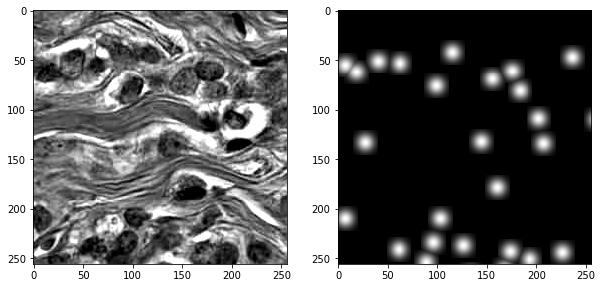

In [9]:
sample_num = np.random.randint(low=0, high=len(X_train))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train[sample_num][:, :, 0], cmap='gray')
axs[1].imshow((y_train[sample_num][:, :, 0] * 255).astype('uint8'), cmap='gray')
plt.show()

## Prepare image generator

In [10]:
data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 100
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=32, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)
train_generator = zip(image_generator, mask_generator)

In [11]:
val_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
val_mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_mask_gen_args)

val_image_datagen.fit(X_val)
val_mask_datagen.fit(y_val)

seed = 100
val_image_generator = val_image_datagen.flow(X_val, seed=seed, batch_size=32, shuffle=True)
val_mask_generator = val_mask_datagen.flow(y_val, seed=seed, batch_size=32, shuffle=True)
val_generator = zip(val_image_generator, val_mask_generator)

## Train model

In [12]:
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred, smooth=2e-126):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

config={
    "input_size": (size, size, 1),
    "output_size": (size, size, 1),
    "loss_function": dice_coef_loss
}

early_stop = keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)

model = None
model = prepare_vnet(config)
model.fit(train_generator, steps_per_epoch=int(np.ceil(len(X_train)/32)), callbacks=[early_stop],
                    epochs=1000, validation_data=val_generator, validation_steps=int(np.ceil(len(X_val)/32)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 312 steps, validate for 36 steps
Epoch 1/1000
312/312 [==============================] - 75s 241ms/step - loss: 0.7189 - mae: 0.1666 - val_loss: 0.9162 - val_mae: 0.1833
Epoch 2/1000
312/312 [==============================] - 67s 215ms/step - loss: 0.2575 - mae: 0.0957 - val_loss: 0.6204 - val_mae: 0.1570
Epoch 3/1000
312/312 [==============================] - 69s 221ms/step - loss: 0.2220 - mae: 0.0875 - val_loss: 0.6823 - val_mae: 0.1749
Epoch 4/1000
312/312 [==============================] - 70s 224ms/step - loss: 0.2190 - mae: 0.0854 - val_loss: 0.4232 - val_mae: 0.1366
Epoch 5/1000
312/312 [==============================] - 68s 217ms/step - loss: 0.2015 - mae: 0.0827 - val_loss: 0.4024 - val_mae: 0.1351
Epoch 6/1000
312/312 [==============================] - 69s 222ms/step - loss: 0.1904 - mae: 0.0798 - val_loss: 0.5488 - val_mae: 0.1539
Epoch 7/1000
312/312 [==============================] - 73s 235ms/step - loss: 0.1971

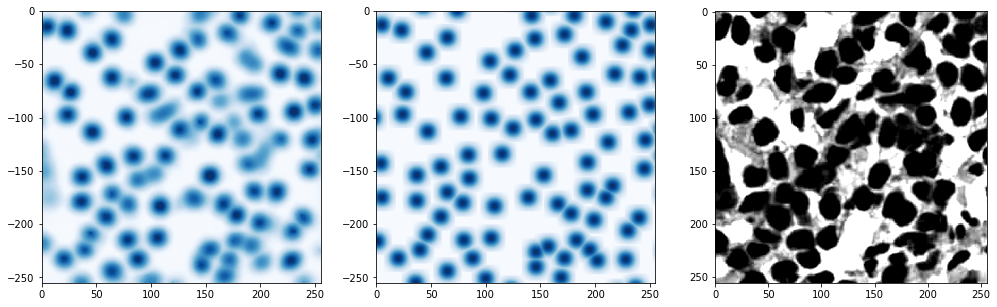

0.006818886 1.0


In [14]:
sample_num = np.random.randint(low=0, high=len(test_mask))
X_test, y_test = random_crop(test_data[sample_num: sample_num+1], test_mask[sample_num: sample_num+1], size, 1)
test_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True)
test_image_datagen = ImageDataGenerator(**test_data_gen_args)
test_image_datagen.fit(X_test)
test_image_generator = test_image_datagen.flow(X_test, batch_size=1)
result = model.predict(test_image_generator)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(17, 5))


y = np.resize(result, (size, size))

X = np.arange(0, len(y))
axs[0].contourf(X, -X, y, 100, cmap='Blues')


y = np.resize(X_test[0], (size, size))
im = Image.fromarray(y)
axs[2].imshow(im, cmap='gray')

y = np.resize(y_test[0], (size, size))

X = np.arange(0, len(y))
axs[1].contourf(X, -X, y, 100, cmap='Blues')
plt.axis('scaled')
plt.show()

print(np.min(result), np.max(result))

In [15]:
model_dir = Path('./models')
os.makedirs(model_dir, exist_ok=True)
model.save(model_dir / 'micai_vnet_model.h5')
model.save_weights(str(model_dir / 'micai_vnet_weights.h5'))

# Train Class dataset

## Preprocess data

In [16]:
data_dir = Path('./data')
proximity_map_path = Path('./data/pmap.h5')
image_dir = Path('./data/imgs')
img_list = os.listdir(image_dir)
img_list.sort()

img_data = []
img_mask = []
coord_data = []
with h5py.File(proximity_map_path, 'r') as file:
    length = len(file['img'].keys())
    for i in tqdm(range(length)):
        img_arr = file.get('img/{:03d}'.format(i))[:]
#         img_arr = rgb_to_sharp_grayscale(img_arr)
        pmap_arr = file.get('pmap/{:03d}'.format(i))[:]
        coord_arr = file.get('xy/{:03d}'.format(i))[:]
        
        coord_data.append(coord_arr)
        
        img_data.append(img_arr)
        img_mask.append(pmap_arr)

In [17]:
train_data, train_mask = img_data[:100], img_mask[:100]
val_data, val_mask = img_data[100:120], img_mask[100:120]
test_data, test_mask = img_data[120:], img_mask[120:]

In [18]:
X_train, y_train = random_crop(train_data, train_mask, size, 100)
print(X_train.shape, y_train.shape)


(10000, 256, 256, 1) (10000, 256, 256, 1)


In [19]:
X_val, y_val = random_crop(val_data, val_mask, size, 100)
print(X_val.shape, y_val.shape)


(2000, 256, 256, 1) (2000, 256, 256, 1)


1.0 1.0
1.0


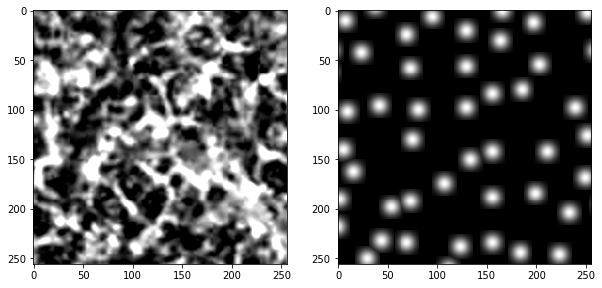

In [20]:
sample_nun = np.random.randint(low=0, high=len(X_train))
resize_x = np.resize(X_train[sample_nun], (size, size))
x_img = Image.fromarray(resize_x)
resize_y = np.resize(y_train[sample_nun], (size, size))
print(np.max(resize_y), np.max(y_train[sample_nun]))
scale_y = resize_y * (255./np.max(resize_y))
y_img = Image.fromarray(scale_y.astype('uint8'))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_img, cmap='gray')
axs[1].imshow(y_img, cmap='gray')

print(np.max(y_train[0].flatten()))

In [21]:
data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 100
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=32, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)
train_generator = (pair for pair in zip(image_generator, mask_generator))

In [22]:
val_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
val_mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_mask_gen_args)

val_image_datagen.fit(X_val)
val_mask_datagen.fit(y_val)

seed = 100
val_image_generator = val_image_datagen.flow(X_val, seed=seed, batch_size=32, shuffle=True)
val_mask_generator = val_mask_datagen.flow(y_val, seed=seed, batch_size=32, shuffle=True)
val_generator = (pair for pair in zip(val_image_generator, val_mask_generator))

## Train model

In [23]:
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred, smooth=2e-126):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


config={
    "input_size": (size, size, 1),
    "output_size": (size, size, 1),
    "loss_function": dice_coef_loss
}

early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
weight_path = str(model_dir / 'micai_vnet_weights.h5')
model = None
model = prepare_vnet(config, weight_path)
model.fit(train_generator, steps_per_epoch=int(np.ceil(len(X_train)/32)), callbacks=[early_stop],
                    epochs=1000, validation_data=val_generator, validation_steps=int(np.ceil(len(X_val)/32)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 63 steps
Epoch 1/1000
313/313 [==============================] - 77s 247ms/step - loss: 0.4633 - mae: 0.1724 - val_loss: 0.5048 - val_mae: 0.1861
Epoch 2/1000
313/313 [==============================] - 73s 233ms/step - loss: 0.4548 - mae: 0.1775 - val_loss: 0.5246 - val_mae: 0.1713
Epoch 3/1000
313/313 [==============================] - 73s 233ms/step - loss: 0.4697 - mae: 0.1811 - val_loss: 0.5116 - val_mae: 0.1827
Epoch 4/1000
313/313 [==============================] - 77s 246ms/step - loss: 0.4565 - mae: 0.1794 - val_loss: 0.5414 - val_mae: 0.1659
Epoch 5/1000
313/313 [==============================] - 76s 243ms/step - loss: 0.4545 - mae: 0.1785 - val_loss: 0.5120 - val_mae: 0.1776
Epoch 6/1000
313/313 [==============================] - 74s 238ms/step - loss: 0.4523 - mae: 0.1777 - val_loss: 0.5206 - val_mae: 0.2047


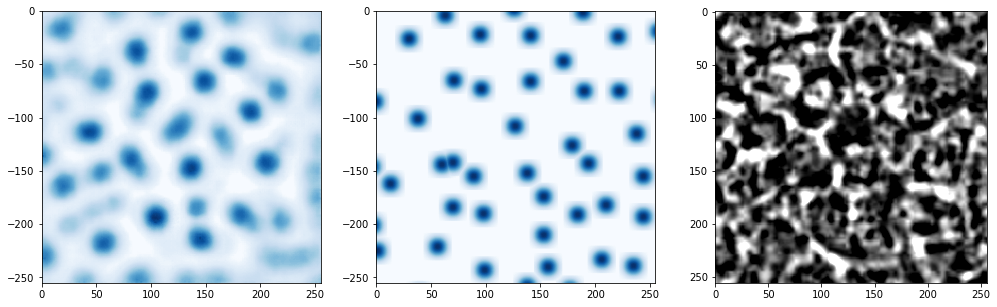

1.0962641e-06 0.79115194


In [25]:
sample_num = np.random.randint(low=0, high=len(test_mask))
X_test, y_test = random_crop(test_data[sample_num: sample_num+1], test_mask[sample_num: sample_num+1], size, 1)
test_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True)
test_image_datagen = ImageDataGenerator(**test_data_gen_args)
test_image_datagen.fit(X_test)
test_image_generator = test_image_datagen.flow(X_test, batch_size=1)
result = model.predict(test_image_generator)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(17, 5))


y = np.resize(result, (size, size))

X = np.arange(0, len(y))
axs[0].contourf(X, -X, y, 100, cmap='Blues')


y = np.resize(X_test[0], (size, size))
im = Image.fromarray(y)
axs[2].imshow(im, cmap='gray')

y = np.resize(y_test[0], (size, size))

X = np.arange(0, len(y))
axs[1].contourf(X, -X, y, 100, cmap='Blues')
plt.axis('scaled')
plt.show()

print(np.min(result), np.max(result))

In [26]:
model.save(Path('./models/class_model.h5'))

# Counting cells

In [27]:
data_dir = Path('./data')
proximity_map_path = Path('./data/pmap.h5')
image_dir = Path('./data/imgs')
img_list = os.listdir(image_dir)
img_list.sort()

img_data = []
img_mask = []
coord_data = []
with h5py.File(proximity_map_path, 'r') as file:
    length = len(file['img'].keys())
    for i in tqdm(range(120, length)):
        img_arr = file.get('img/{:03d}'.format(i))[:]
        pmap_arr = file.get('pmap/{:03d}'.format(i))[:]
        coord_arr = file.get('xy/{:03d}'.format(i))[:]
        
        coord_data.append(coord_arr)
        
        img_data.append(img_arr)
        img_mask.append(pmap_arr)
        
test_data, test_mask = img_data, img_mask

## Generate prediction map

In [28]:
def generate_image_patches(img, size):
    max_x = int(np.ceil(img.shape[0]/ size))
    max_y = int(np.ceil(img.shape[1]/ size))
    
    center_coords = []
    x_interval = ((img.shape[0] - size/2.) - (size/2.)) / (max_x-1)
    y_interval = ((img.shape[1] - size/2.) - (size/2.)) / (max_y-1)
    
    for i in range(max_x):
        for j in range(max_y):
            if i == 0:
                x = int(size/2.)
            elif i == max_x - 1:
                x = int(img.shape[0] - size/2.)
            else:
                x = int(size/2. + i * x_interval)
            
            if j == 0:
                y = int(size/2.)
            elif j == max_y -1:
                y = int(img.shape[1] - size/2.)
            else:
                y = int(size/2. + j * y_interval)
                
            center_coords.append([x,y])
            
    ones_array = np.full((size, size), 1.)
    weight_array = np.full((img.shape), 0.)

    image_patches = []
    for i in range(len(center_coords)):
        weight_array[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.), center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)] += ones_array
        image_patches.append(img[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.), center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)])
        
    weight_array = 1./weight_array
    
    return image_patches, center_coords, weight_array

def reconstruct_image_patches(image_patches, center_coords, size, weight_array):
    reconstruct_img = np.full(weight_array.shape, 0.)
    for i in range(len(image_patches)):
        reconstruct_img[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.),
                   center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)] += image_patches[i]
    
    reconstruct_img = np.multiply(reconstruct_img, weight_array)
    return reconstruct_img

In [38]:
import time
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
patch_size = 256
model = load_model(Path('./models/class_model.h5'), compile=False)
test_data_path = Path('./data/test_data.h5')

with h5py.File(test_data_path, 'w') as file:
    for k in tqdm(range(len(test_data))):
        sample_num = k
        image_patches, center_coords, weight_array = generate_image_patches(test_data[sample_num], patch_size)
        resize_image_patches = []
        xy_offset = []

        for i in range(len(image_patches)):
            resize_image_patches.append(np.resize(image_patches[i], (patch_size, patch_size, 1)))
            xy_offset.append([center_coords[i][0] - int(patch_size/2.), center_coords[i][1] - int(patch_size/2.)])

        resize_image_patches = np.array(resize_image_patches)  
        xy_offset = np.array(xy_offset)

        test_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True)
        test_image_datagen = ImageDataGenerator(**test_data_gen_args)
        test_image_datagen.fit(resize_image_patches)
        test_image_generator = test_image_datagen.flow(resize_image_patches, batch_size=1, shuffle=False)
        result = model.predict(test_image_generator)

        resize_result = np.resize(result, (len(result), patch_size, patch_size)) 
        
        file.create_dataset('original/{:03}'.format(k), data=test_data[sample_num])
        file.create_dataset('predict_patches/{:03}'.format(k), data=resize_result)
        file.create_dataset('ground_truth/{:03}'.format(k), data=test_mask[k])
        file.create_dataset('xy_offset/{:03}'.format(k), data=xy_offset)

## Count cell from prediction map

In [39]:
sample_num = 4
with h5py.File(test_data_path, 'r') as file:
    image_patches = file.get('predict_patches/{:03}'.format(sample_num))[:]
    image_patches = np.reshape(image_patches, (len(image_patches), 256, 256))
    original_img = file.get('original/{:03}'.format(sample_num))[:]
    ground_truth = file.get('ground_truth/{:03}'.format(sample_num))[:]
    xy_offset = file.get('xy_offset/{:03}'.format(sample_num))[:]

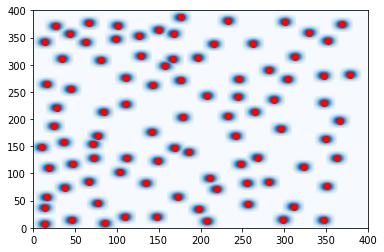

90


In [40]:
centroid_locs = np.argwhere(ground_truth == 1.0)
centroid_num = len(centroid_locs)

X = np.arange(0, len(ground_truth))
plt.contourf(X, X, ground_truth, 100, cmap='Blues')
plt.scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.show()
print(centroid_num)

(45, 2)


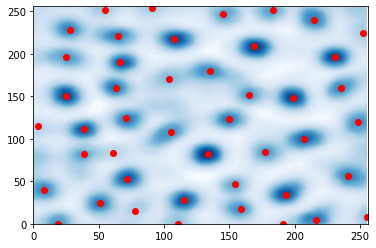

(45, 2)


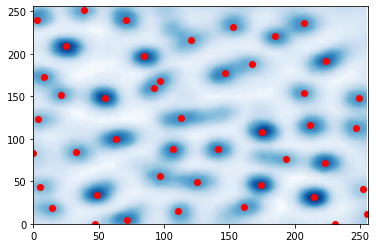

(49, 2)


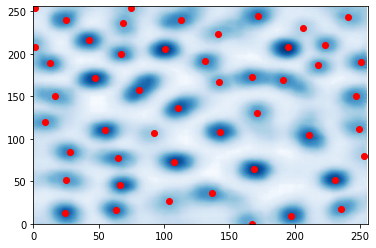

(47, 2)


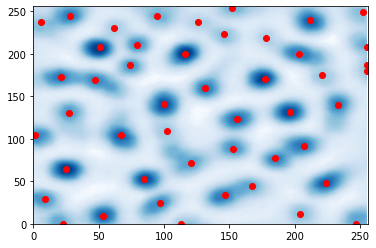

In [41]:
neighborhood_size = 12
threshold = 0.07

global_coords = []

for i in range(len(image_patches)):
    data = image_patches[i]
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    coords = []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        y_center = (dy.start + dy.stop - 1)/2    
        coords.append([x_center, y_center])
        global_coords.append([x_center + xy_offset[i][1], y_center + xy_offset[i][0]])

    coords = np.array(coords)
    print(coords.shape)
    
    X = np.arange(0, len(data))
    plt.contourf(X, X, data, 100, cmap='Blues')
    plt.scatter(coords[:, 0], coords[:, 1], c='r')
    plt.xlim(0, len(data))
    plt.ylim(0, len(data))
    plt.show()
    
global_coords = np.array(global_coords)

In [42]:
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    ret = np.array(ret)
    return ret

def remove_edge_point(points, size, threshold=5.):
    result = []
    for i in points:
        if i[0] <= threshold or i[1] <= threshold or i[0] >= size-threshold-1 or i[1] >= size-threshold-1:
            continue
        result.append(i)
    return np.array(result)

fuse_points = fuse(global_coords, 12)
fuse_points = remove_edge_point(fuse_points, 400.)

In [ ]:
X = np.arange(0, len(ground_truth))
fig, axs = plt.subplots(1, 3, figsize=(17, 5))


axs[0].contourf(X, X, ground_truth, 100, cmap='Blues')
axs[0].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
axs[0].scatter(fuse_points[:, 0], fuse_points[:, 1], c='k')
axs[0].set_xlim(0, len(ground_truth))
axs[2].set_ylim(0, len(ground_truth))
axs[0].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))

axs[1].contourf(X, X, original_img, 100, cmap='gray')
axs[1].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
axs[1].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b')
axs[1].set_xlim(0, len(ground_truth))
axs[2].set_ylim(0, len(ground_truth))
axs[1].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))

img_dir = Path('./data/upscale_rgb')
img_list = os.listdir(img_dir)
img_list.sort()
img = np.array(Image.open(img_dir / img_list[120+sample_num]))
axs[2].imshow(img)
axs[2].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
axs[2].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b')
axs[2].set_xlim(0, len(ground_truth))
axs[2].set_ylim(0, len(ground_truth))
axs[2].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))
plt.show()

In [ ]:
def full_test(sample_num, data_path, patch_size, graph=False):
    with h5py.File(test_data_path, 'r') as file:
        image_patches = file.get('predict_patches/{:03}'.format(sample_num))[:]
        image_patches = np.reshape(image_patches, (len(image_patches), patch_size, patch_size))
        original_img = file.get('original/{:03}'.format(sample_num))[:]
        ground_truth = file.get('ground_truth/{:03}'.format(sample_num))[:]
        xy_offset = file.get('xy_offset/{:03}'.format(sample_num))[:]
        
    centroid_locs = np.argwhere(ground_truth == 1.0)
    centroid_num = len(centroid_locs)
    
    neighborhood_size = 12
    threshold = 0.07

    global_coords = []

    for i in range(len(image_patches)):
        data = image_patches[i]
        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        coords = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            y_center = (dy.start + dy.stop - 1)/2    
            coords.append([x_center, y_center])
            global_coords.append([x_center + xy_offset[i][1], y_center + xy_offset[i][0]])

        coords = np.array(coords)

    global_coords = np.array(global_coords)
    fuse_points = fuse(global_coords, 12)
    fuse_points = remove_edge_point(fuse_points, 400.)
    
    if graph:
        X = np.arange(0, len(ground_truth))
        fig, axs = plt.subplots(1, 3, figsize=(17, 5))


        axs[0].contourf(X, X, ground_truth, 100, cmap='Blues')
        axs[0].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
        axs[0].scatter(fuse_points[:, 0], fuse_points[:, 1], c='k')
        axs[0].set_xlim(0, len(ground_truth))
        axs[0].set_ylim(0, len(ground_truth))
        axs[0].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))

        axs[1].contourf(X, X, original_img, 100, cmap='gray')
        axs[1].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
        axs[1].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b')
        axs[1].set_xlim(0, len(ground_truth))
        axs[0].set_ylim(0, len(ground_truth))
        axs[1].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))
        
        img_dir = Path('./data/upscale_rgb')
        img_list = os.listdir(img_dir)
        img_list.sort()
        img = np.array(Image.open(img_dir / img_list[120+sample_num]))
        axs[2].imshow(img)
        axs[2].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r')
        axs[2].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b')
        axs[2].set_xlim(0, len(ground_truth))
        axs[2].set_ylim(0, len(ground_truth))
        axs[2].set_title('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))
        plt.show()
        
    y_true = float(centroid_num)
    y_pred = float(len(fuse_points))
    
    error = np.abs(y_pred - y_true) / y_true * 100
    return len(fuse_points), centroid_num, error

In [ ]:
sample_num = np.random.randint(low=0, high=23)
print(img_list[120 + sample_num])
full_test(sample_num, test_data_path, 256, graph=True)

In [ ]:
acc = []
for i in tqdm(range(23)):
    result = full_test(i, test_data_path, 256, graph=False)
    acc.append(result[2])
    
print('Avg error: {}'.format(np.mean(acc)))